# Статистика, DS-поток
## Задание SP.13

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.



**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


**Баллы за задание.**


Практика:
* Задача P1 &mdash; 70 баллов;
* Задача P2 &mdash; 70 баллов.

**Важность задач:**

* *высокая:* все задачи :)

In [45]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='Set2')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score as P, recall_score as R, accuracy_score as Ac
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from torch import nn
from torchvision import models
import torchvision 
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import os
from glob import glob
import random
random.seed(10)
from sklearn.base import BaseEstimator

In [44]:
# Bot check

# HW_ID: ds_sp13
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

---
### Задача P1.


На семинаре мы рассмотрели различные подходы к калибровке классификационных моделей. Но помимо этого хочется иметь метрики калибровки для сравнения качества полученных моделей.

Сгенерируем выборку, в которой классы не являются линейно-разделимыми, а также добавим к ней фоновый шум из точек разных классов.

Используйте функцию `make_blobs`.

(1000, 2) (1000,)


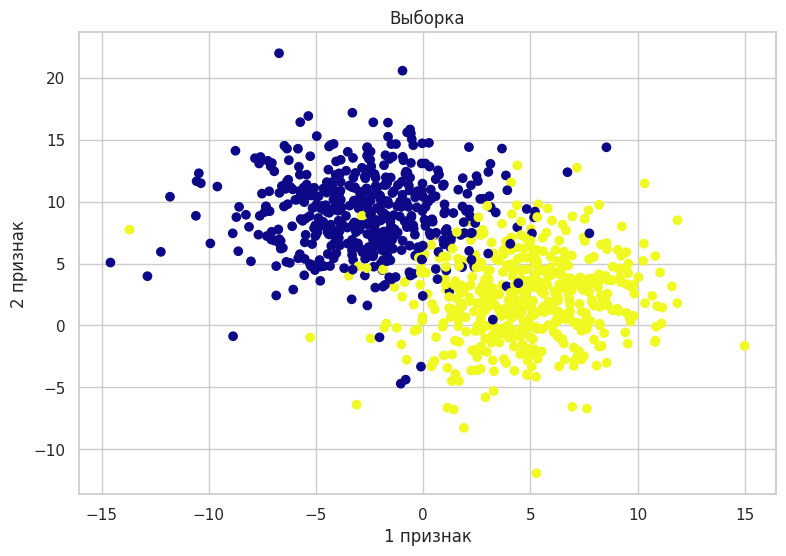

In [46]:
X, y = make_blobs(n_samples=950, centers=2, n_features=2, cluster_std=3.0, random_state=42)  # сами данные
X_noise, y_noise = make_blobs(n_samples=50, centers=2, n_features=2, cluster_std=7.0, random_state=42)  # шум
X, y = np.vstack((X, X_noise)), np.hstack((y, y_noise))
print(X.shape, y.shape)

plt.figure(figsize=(9,6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='plasma', marker='o')
plt.title('Выборка')
plt.xlabel('1 признак')
plt.ylabel('2 признак')
plt.grid(True)
plt.show()

*Видно, что классы не являются линейно разделимыми*

Разделите выборку на обучение, валидацию и тест.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучите любые три классификационные модели на данных, выведите их метрики.

In [48]:
models, metrics =  {'lr': LogisticRegression(), 'rf': RandomForestClassifier(), 'gb': GradientBoostingClassifier()}, {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics[model_name] = [metric(y_test, y_pred) for metric in [P,R,Ac]]

metrics = pd.DataFrame(metrics, index=['Precision','Recall','Accuracy']).round(3)
display(metrics)

,lr,rf,gb
Precision,0.911,0.899,0.882
Recall,0.943,0.920,0.943
Accuracy,0.935,0.920,0.920


*Модели обучились неплохо*

Отрисуйте калибровочные кривые и гистограммы предсказаний данных моделей. Какие выводы можно сделать?

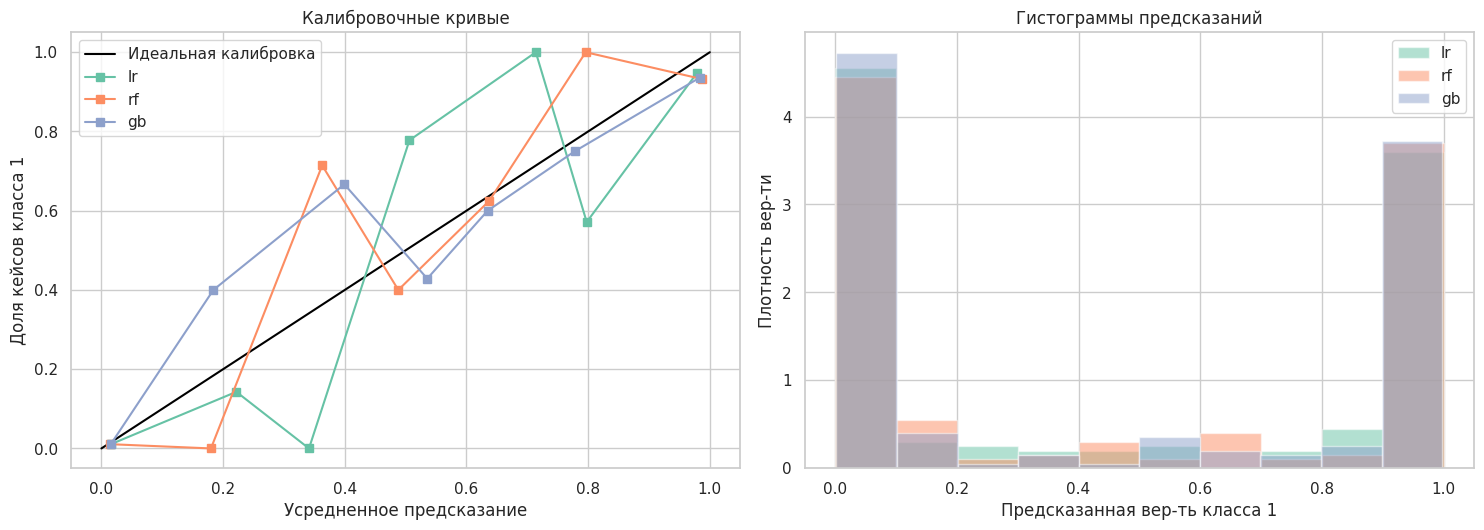

In [49]:
def plot_calibr(models, n_bins):
    plt.figure(figsize=(15,10))
    for i, (name, model) in enumerate(models.items()):
        y_proba = model.predict_proba(X_test)[:,1]
        pos_frac, mean_pred = calibration_curve(y_test, y_proba, n_bins=n_bins)
        plt.subplot(2, 2, 1)
        if i==0:
            plt.plot([0,1], [0,1], color='black', label="Идеальная калибровка")
        plt.plot(mean_pred, pos_frac, "s-", label=name)
        plt.title('Калибровочные кривые')
        plt.xlabel('Усредненное предсказание')
        plt.ylabel('Доля кейсов класса 1')
        plt.legend()
        plt.subplot(2, 2, 2)
        plt.hist(y_proba, bins=10, alpha=0.5, label=name, density=True)
        plt.legend()
        plt.title('Гистограммы предсказаний')
        plt.xlabel('Предсказанная вер-ть класса 1')
        plt.ylabel('Плотность вер-ти')
    plt.tight_layout()
    plt.show()

plot_calibr(models, n_bins=7)

Откалибруйте модели. И посмотрите на кривые для новых моделей. Сделайте выводы.

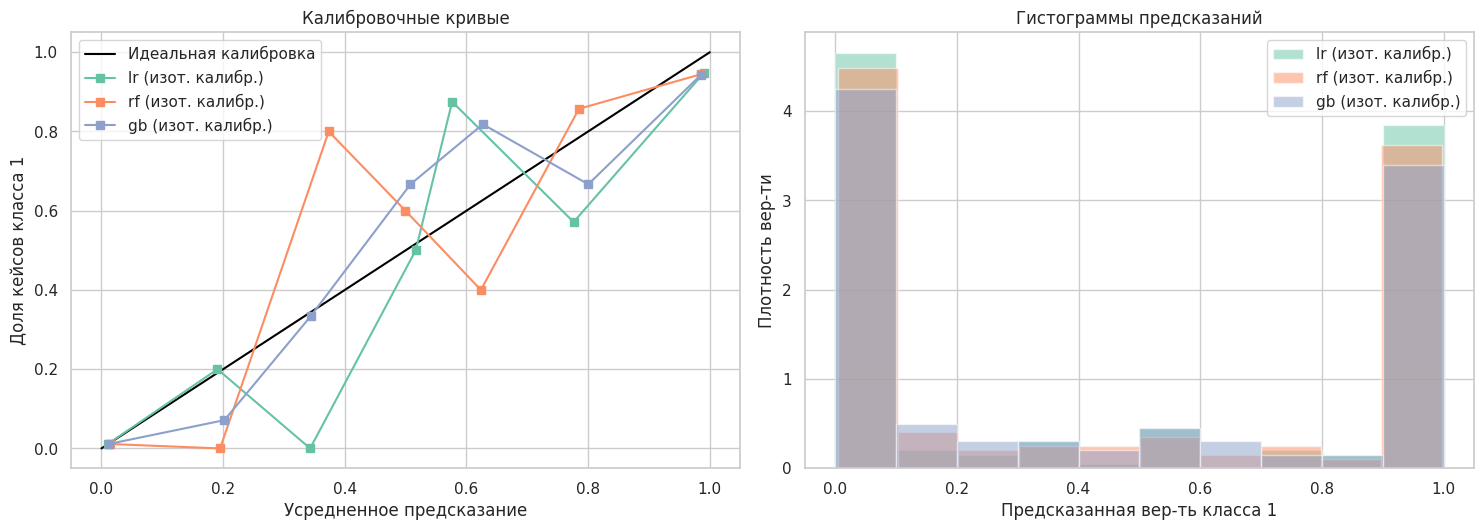

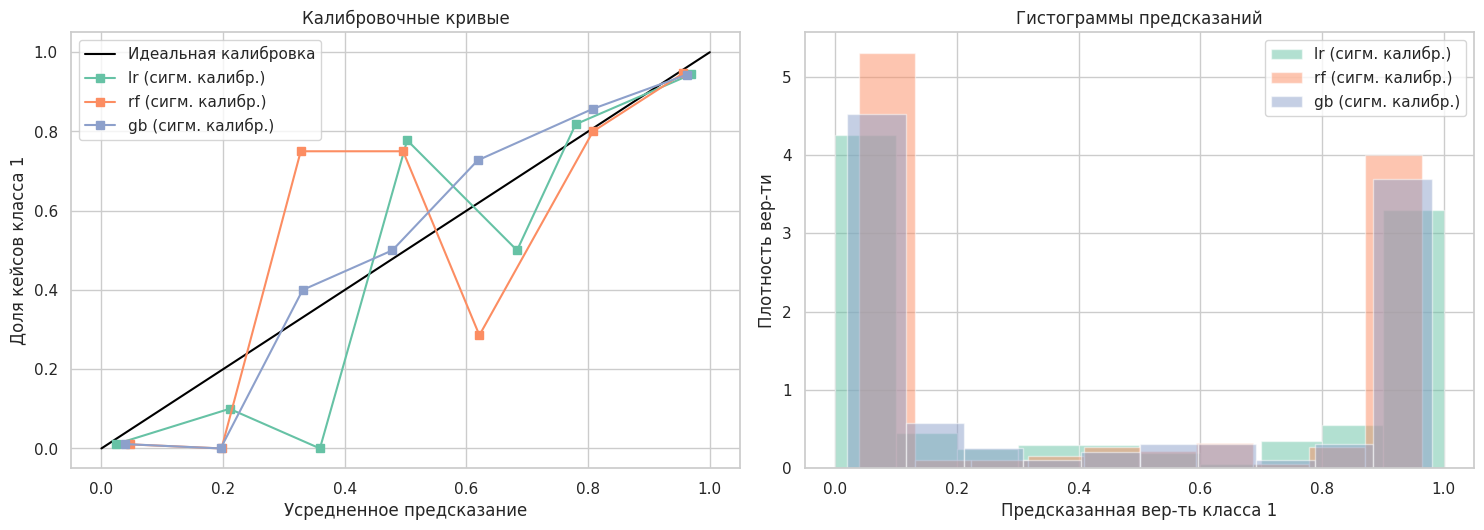

In [50]:
models_calibrated_isot = {f'{name} (изот. калибр.)': CalibratedClassifierCV(estimator=model, method='isotonic').fit(X_train, y_train) for name, model in models.items()}
plot_calibr(models_calibrated_isot, n_bins=7)
models_calibrated_sigm = {f'{name} (сигм. калибр.)': CalibratedClassifierCV(estimator=model, method='sigmoid').fit(X_train, y_train) for name, model in models.items()}
plot_calibr(models_calibrated_sigm, n_bins=7)

*Видно, что после дополнительной обработки калибровочная кривая приблизилась к y=x, т.е. выход моделей стал лучше аппроксимировать вероятность позитивного класса*

---

Для оценки калибровки используются, как правило, две метрики:
- Expected Callibration Error
- Brier Score

**Expected Callibration Error**

Данная метрика наследует идеи гистограммной калибровки. Пусть $B_1, \dots, B_k$ &mdash; разбиение отрезка $[0, 1]$ на непересекающиеся бины.

$$ECE = \sum_{j = 1}^k \cfrac{\sum_{i=1}^n I\{x_i \in B_j\}}{n} \left|\overline{y}(B_j) - \overline{p}(B_j)\right|$$

**Brier Score**

Данный подход ближе к изотонической регрессии.
$$BS = \sum_{i=1}^n (y_i - p(x_i))^2.$$
Причем в качестве функции разницы рассматривают не только квадратичную ошибку.

---

Реализуйте функции для подстчета метрик:

In [51]:
def ECE(y_true, y_prob, n_bins=10):  # чем ближе к 0, тем лучше
    ece, bin_indices = 0.0, np.digitize(y_prob, np.linspace(0, 1, n_bins+1)) - 1
    for j in range(n_bins):
        indices_in_bin = np.where(bin_indices==j)[0]  # попали в jй бин
        if len(indices_in_bin)==0:
            continue
        ece += len(indices_in_bin) * abs(np.mean(y_true[indices_in_bin]) - np.mean(y_prob[indices_in_bin]))
    return ece / len(y_true)

def BS(y_true, y_prob):  # чем ближе к 0, тем лучше
    return np.linalg.norm(np.array(y_true-y_prob))**2

Проанализируйте, какой метод калибровки лучше подоходит для каждой из моделей.

In [52]:
for mode, models_ in zip(['До калибровки','Изот. калибровка','Сигм. калибровка'],[models,models_calibrated_isot,models_calibrated_sigm]):
    metrics_calibr = {}
    for name, model in models_.items():
        y_proba = model.predict_proba(X_test)[:,1]
        metrics_calibr[name] = [metric(y_test, y_proba) for metric in [ECE,BS]]
    metrics_calibr = pd.DataFrame(metrics_calibr, index=['ECE','BS']).round(3)
    print(mode)
    display(metrics_calibr)

До калибровки


,lr,rf,gb
ECE,0.049,0.040,0.039
BS,11.077,11.471,11.954


Изот. калибровка


,lr (изот. калибр.),rf (изот. калибр.),gb (изот. калибр.)
ECE,0.063,0.065,0.037
BS,10.568,12.048,12.157


Сигм. калибровка


,lr (сигм. калибр.),rf (сигм. калибр.),gb (сигм. калибр.)
ECE,0.057,0.049,0.052
BS,11.372,11.631,11.274


*Судя по значениям `ECE` в таблицах выше, изотоническая калибровка немного помогла градиентному бустингу (хотя результат `BS` с этим не согласован). По той же метрике, во всех остальных случаях калибровки только навредили*  
*Судя по значениям `BS` в таблицах выше, изотоническая калибровка немного помогла логистической регрессии (хотя результат `ECE` с этим не согласован), а сигмоидальная - случайному лесу и градиентному бустингу (тоже в противовес результатам `ECE`). По той же метрике, во всех остальных случаях калибровки только навредили*  
*В общем, какие-то надежные выводы по доступным данным сделать сложно. Похоже, эффект от калибровок сильно зависит от конкретной задачи и может быть довольно непредсказуемым (что логично, ведь калибровки - это по сути подгон)* 

**Вывод:**

*В этой задаче удалось ближе познакомиться с калибровками. Стоит помнить, что калибровка - это все же некоторый подгон. Поэтому применять ее слишком часто не стоит: разве что для небольшой подстройки готовой модели*

---
### Задача P2.


Исследуем, насколько скалиброванны нейронные сети. Рассмотрим датасет <a href="https://www.kaggle.com/datasets/chetankv/dogs-cats-images">Dogs & Cats Images</a>. Требуется определить, кто изображен на картинке &mdash; собака или кошка.

Выделите из обучающего набора выделите трейн и валидацию в соотношении 3:1.

In [53]:
root = '../input/dogs-cats-images/dataset'
test_images = glob(f'{root}/test_set/*/*')
train_val_cats, train_val_dogs = glob(f'{root}/training_set/cats/*'), glob(f'{root}/training_set/dogs/*')
val_images = random.sample(train_val_cats, len(train_val_cats)//4) + random.sample(train_val_dogs, len(train_val_dogs)//4)
train_images = list(set(train_val_cats+train_val_dogs) - set(val_images))
assert len(set(train_images).intersection(set(val_images))) == 0  # ликов нет

In [54]:
class CatsDogsDataset(Dataset):
    def __init__(self, mode='train', transform=None):
        self.img_paths = {'train':train_images, 'val':val_images, 'test':test_images}[mode]
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.img_paths[idx]))
        label = 1 if self.img_paths[idx].split('/')[-2] == 'cats' else 0
        if self.transform:
            img = self.transform(image=img)["image"]
        return img, label

size = (256,256)
train_transform = A.Compose([
    A.Resize(*size),  
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
val_test_transform = A.Compose([
    A.Resize(*size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

batch_size, num_workers = 32, 2
train_dataset = CatsDogsDataset('train', transform=train_transform)
val_dataset = CatsDogsDataset('val', transform=val_test_transform)
test_dataset = CatsDogsDataset('test', transform=val_test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Постройте простую сверточную нейронную сеть для классификации изображений и обучите ее на тренировочной части данных. Используйте хотя бы несколько сверточных слоев, но слишком много не стоит.

In [55]:
cnn = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), 
    nn.Flatten(),
    nn.Linear(256 * 32 * 32, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).cuda()

Эпоха (val): 10, лосс: 0.930: 100%|██████████| 10/10 [03:22<00:00, 20.23s/it] 


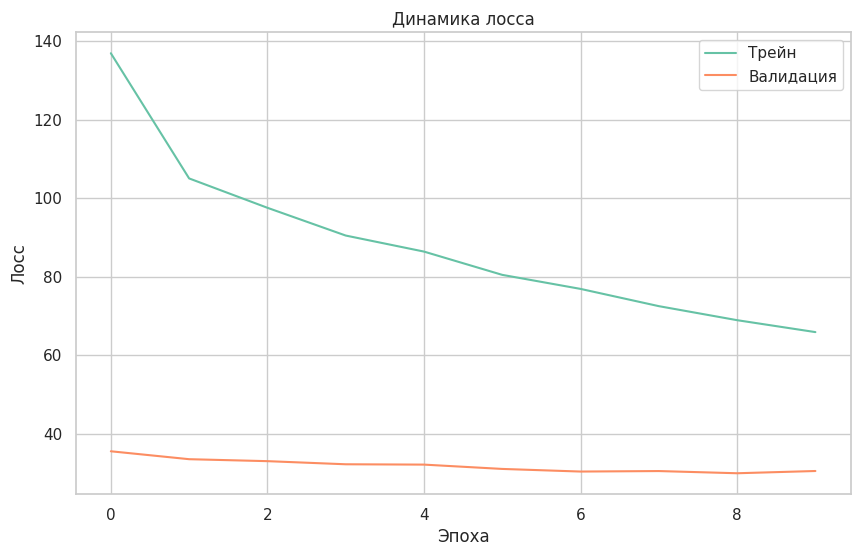

In [56]:
def train(model, num_epochs=10, lr=3e-4):
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    pbar = tqdm(range(num_epochs))
    train_history, val_history = [], []
    
    for epoch in pbar:
        model.train()
        epoch_loss = 0.0
        for i, (imgs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = torch.sigmoid(model(imgs.cuda())[:,0])
            loss = criterion(outputs, labels.float().cuda())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_description(f"Эпоха (train): {epoch+1}, лосс: {loss:.3f}")
        train_history.append(epoch_loss)

        model.eval()
        with torch.no_grad():
            epoch_loss = 0.0
            for i, (imgs, labels) in enumerate(val_loader):
                outputs = torch.sigmoid(model(imgs.cuda())[:,0])
                loss = criterion(outputs, labels.float().cuda())
                epoch_loss += loss.item()
                pbar.set_description(f"Эпоха (val): {epoch+1}, лосс: {loss:.3f}")
            val_history.append(epoch_loss)   
    return train_history, val_history
    
train_history, val_history = train(cnn)
fig = plt.figure(figsize=(10,6))  # графики просто чтобы убедиться, что учится
plt.plot(train_history, label='Трейн')
plt.plot(val_history, label='Валидация')
plt.title('Динамика лосса')
plt.xlabel('Эпоха')
plt.ylabel('Лосс')
plt.legend()
plt.show()

Также выберите один из <a href="https://pytorch.org/vision/stable/models.html">видов архитектруры</a> нейронной сети для классификации изображений из torchvision, например, ResNet. Определите для него 3 варианта архитектуры с разным количеством параметров.

In [57]:
resnets = [
    torchvision.models.resnet18(weights='DEFAULT'),
    torchvision.models.resnet34(weights='DEFAULT'),
    torchvision.models.resnet50(weights='DEFAULT')
]
for n in resnets:
    n.fc = nn.Linear(n.fc.in_features, 1)
resnets = [n.cuda() for n in resnets]

Эпоха (val): 10, лосс: 0.569: 100%|██████████| 10/10 [03:27<00:00, 20.79s/it] 


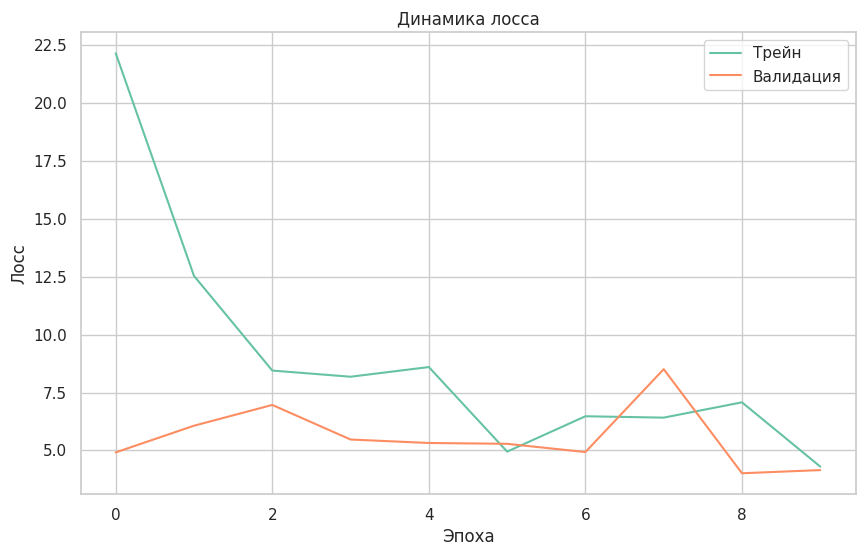

Эпоха (val): 10, лосс: 0.502: 100%|██████████| 10/10 [04:07<00:00, 24.80s/it] 


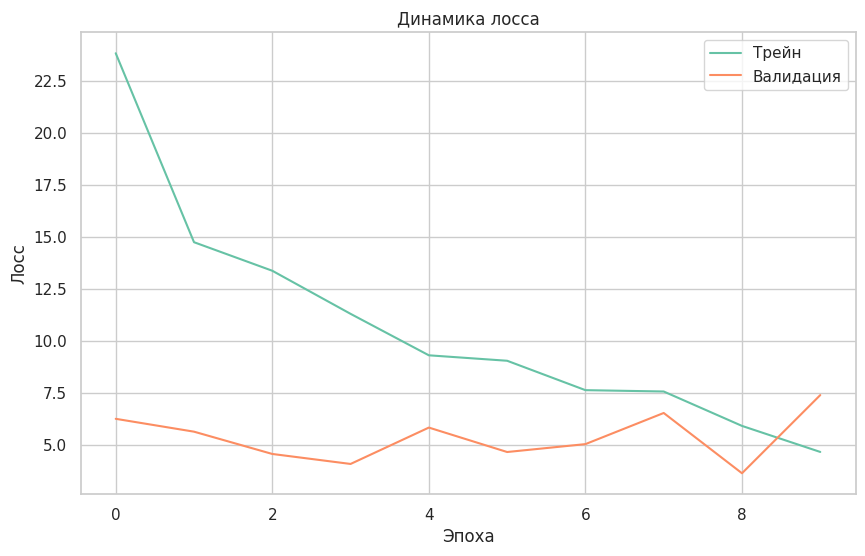

Эпоха (val): 10, лосс: 0.204: 100%|██████████| 10/10 [07:18<00:00, 43.84s/it] 


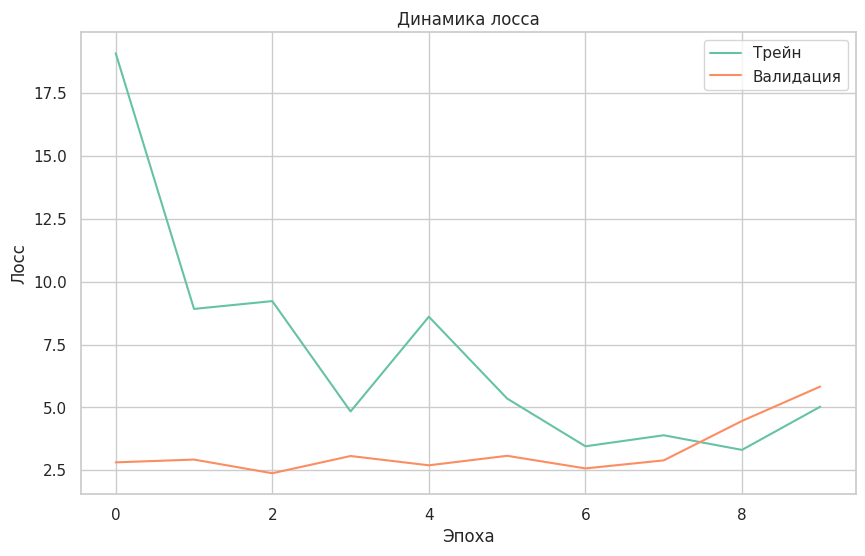

In [58]:
for model in resnets:
    train_history, val_history = train(model)
    fig = plt.figure(figsize=(10,6))  # графики просто чтобы убедиться, что учится
    plt.plot(train_history, label='Трейн')
    plt.plot(val_history, label='Валидация')
    plt.title('Динамика лосса')
    plt.xlabel('Эпоха')
    plt.ylabel('Лосс')
    plt.legend()
    plt.show()

Для каждой рассмотренной ранее модели выполните следующие действия.
* Посмотрите на калибровочную кривую и оценку качества калибровки.
* Примените методы калибровки и сравните результаты. Посчитайте, как изменилась точность классификации на тестовой части данных.

Поясните, почему калибровку необходимо выполнять на валидационной части данных, а оценивать точность классификации &mdash; на тестовом.

*Калибровку нельзя проводить на трейне, т.к. подгон под трейн приведет к оверфиту. Нельзя калиброваться и на тесте: тест - это отложенная выборка, которую вообще нельзя трогать из-за риска подогнаться под нее и исказить представления о работе модели. Остается только валидация. А тест стандартно используется для оценки качества финальной модели*

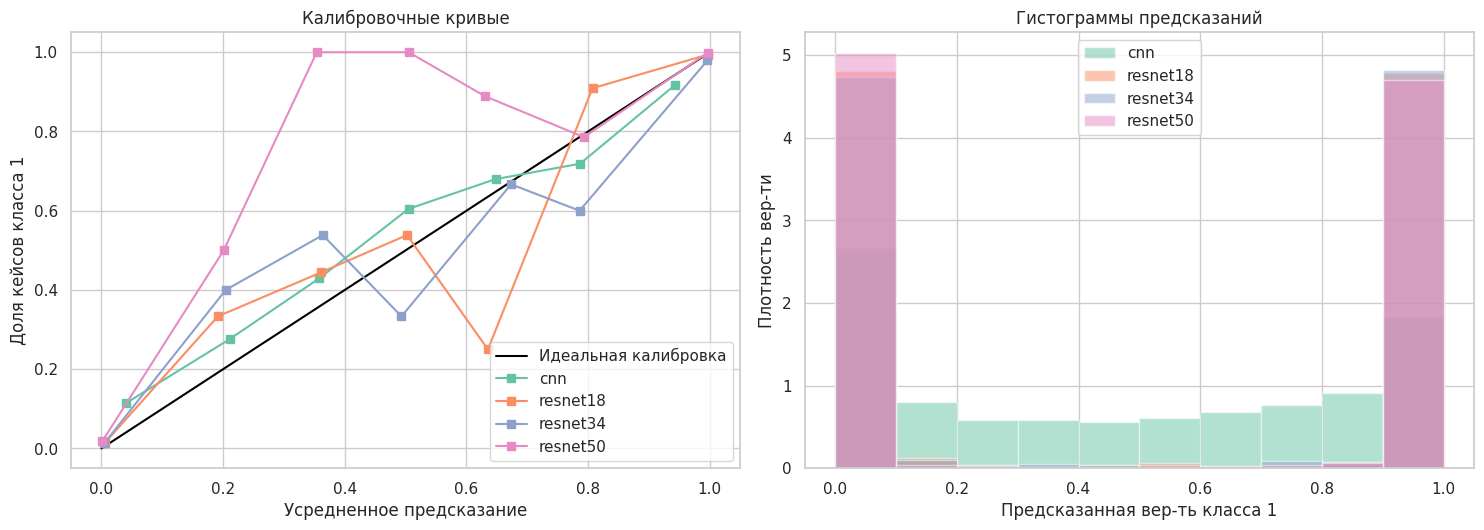

In [59]:
names, models = ['cnn','resnet18','resnet34','resnet50'], [n.eval() for n in [cnn, *resnets]]

def plot_calibr_nets(models, n_bins=7):
    plt.figure(figsize=(15,10))
    for j, (name, M) in enumerate(zip(names, models)):
        y_test, y_proba = [], []
        with torch.no_grad():
            for imgs, labels in test_loader:
                y_test.append(labels)
                y_proba.append(torch.sigmoid(M(imgs.cuda())[:,0]).cpu())
        y_test, y_proba = torch.cat(y_test), torch.cat(y_proba)
        # print(y_test.shape, y_proba.shape)
        pos_frac, mean_pred = calibration_curve(y_test, y_proba, n_bins=n_bins)
        plt.subplot(2, 2, 1)
        if j==0:
            plt.plot([0,1], [0,1], color='black', label="Идеальная калибровка")
        plt.plot(mean_pred, pos_frac, "s-", label=name)
        plt.title('Калибровочные кривые')
        plt.xlabel('Усредненное предсказание')
        plt.ylabel('Доля кейсов класса 1')
        plt.legend()
        plt.subplot(2, 2, 2)
        plt.hist(y_proba, bins=10, alpha=0.5, label=name, density=True)
        plt.legend()
        plt.title('Гистограммы предсказаний')
        plt.xlabel('Предсказанная вер-ть класса 1')
        plt.ylabel('Плотность вер-ти')
    plt.tight_layout()
    plt.show()
    
plot_calibr_nets(models)

*Самодельная cnn справляется хуже (судя по гистограмме, выдает много неуверенных ответов).*   
*resnet50 - слишком большая и переобучилась. Судя по калибровочной кривой, у нее слишком высокая уверенность*  
*resnet18 - слишком маленькая и немного недообучилась. Судя по калибровочной кривой, у нее немного заниженная уверенность*   
*resnet34 - посередине*   
*Вывод: чем больше параметров, тем проще переобучить сеть, и тем выше ее уверенность в ответах*   

In [60]:
class Wrap(BaseEstimator):
    def __init__(self, network):
        self.network = network

    def fit(self, X, y):
        train(self.network)

    def predict_proba(self, X):
        return torch.sigmoid(self.network(torch.tensor(X).cuda())[:,0]).cpu()

models_calibrated_isot = {f'{name} (изот. калибр.)': CalibratedClassifierCV(estimator=Wrap(model), method='isotonic').fit(X_train, y_train) 
                          for name, model in zip(names, models)}
plot_calibr_nets(models_calibrated_isot, n_bins=7)
models_calibrated_sigm = {f'{name} (сигм. калибр.)': CalibratedClassifierCV(estimator=Wrap(model), method='sigmoid').fit(X_train, y_train) 
                          for name, model in zip(names, models)}
plot_calibr_nets(models_calibrated_sigm, n_bins=7)

Эпоха (val): 10, лосс: 0.676: 100%|██████████| 10/10 [03:22<00:00, 20.21s/it] 


RuntimeError: Input type (double) and bias type (float) should be the same

Сделайте выводы.

*В этой задаче удалось изучить применимость калибровок к нейросетям и пронаблюдать ряд закономерностей*